# All-pole model prior $p(x,y)$

## Model

Fourier transform convention: (same as Eq. 1 in FT wiki page):

$$ \tilde{f}(x) = \int f(t) e^{-2\pi i xt} dt $$

This is equivalent to choosing units Hz (or kHz) for $x$ rather than rad/s or rad/msec. See `test_core.ipynb` for more on this. Also equivalent to a Laplace transform with $s = 2\pi i x$.

Impulse response for $K$ poles $p_k = -\pi y_k + 2\pi i x_k$:

$$ h(t; p) = (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t}$$

The coefficients are given by "the excluded pole product":

$$ c_k = \lim_{x \rightarrow p_k} (x - p_k) \tilde{h}(x; p) = {G \over \prod (p_k - p_1) (p_k - p_1^*) \ldots (p_k - p_k^*) \ldots (p_k - p_K) (p_k - p_K^*)} $$

where the gain $G = \prod_{k=1}^K |p_k|^2$ and $\tilde{h}(x; p)$ is defined below.

See @Arfken2005 for a reference on partial fraction expansions (PFEs). We
simply use the limit formula.

The formula for

$$p_k = -\pi y_k + 2\pi i x_k$$

comes from -3 dB bandwidth point and Fourier convention (since $x$ and $y$ are in kHz rather than rad/msec -- that's why we have to multiply by multiples of $\pi$). We use kHz for $p$ because $t$ is given in msec.

Transfer function: (Fourier transform of $h(t; p)$ with our convention)

$$ \tilde{h}(x; p) = {G \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

Note that the overall scale is determined by the DGF, so we normalize such that $h(0, p) = 1$.

## More on normalization

Unfortunately, it is not so easy to derive constraints on the energy or power (i.e. energy over a time interval divided by the time interval's length). The energy (i.e. $\int h(t)^2 dt$) of the impulse response is by Parseval's theorem equal to the energy contained in the transfer function, but it's not possible to derive hard constraints -- [energy is not preserved by convolution!](https://math.stackexchange.com/a/1154656/566289). [The best I got is $\int_0^\tau d(t)^2 dt \approx \tau \leq \int |\tilde{h}(x)|^4 dx \int |\tilde{u}(x)|^4 dx$].

A more useful way to proceed is to rely on the typical values of peak amplitudes -- these are typically of the same order as the squared power of the signal -- because we know that these must be of the same order for $d$, $u$, $h$ if we the output $d(t)$ is to be "made" from a convolution of $u$ and $h$.

And in this sense the AP normalization adapted above is not too bad since it has peak amplitudes of O(10). We would prefer O(1) because data $d(t)$ has peak amplitudes O(2) (because of the power normalization) and source DGF $u(t)$ has peak amplitudes O(5). Still, AP normalization is cheap, conventional and produces results that are reasonable. The PZ model (see polezero.ipynb) can do much better in this regard because the amplitudes are free and we can constrain the power in the impulse response analytically using a ME prior -- we set $\mu^2 := 1\ msec$ and the peak amplitudes are magically O(1) as well!

**Note:** The only thing we can assert about power is that $|\tilde{h}(x; p)| \leq 1$ for all frequencies $x$ if we believe that the [VTR is a passive filter](https://dsp.stackexchange.com/a/28881/65430). But I think the lossless open tube model of the VTR is in fact active by this criterion, so best to stay away from this. In any case it is quite difficult to normalize for the passive condition and keep everything tractable.

## Do poles measure VTRs?

"Formants are easy to measure, VTRs aren't" @Whalen2022

In our view, poles are simply an expansion of the "true" transfer function. And we focus on formants, which are highly nonlinear functions of the poles.

Therefore, it is dangerous to identify them directly with VTRs, especially in such a simple linear approximation to the system (i.e., source-filter theory). For example, pole (resonance) amplitudes are not free parameters; they are determined by all the poles together -- this seems like a strong simplification: surely the resonance amplitude should be a free parameter? (For example by expanding the transfer function in a Gaussian mixture.)

Contra AP model:
- Less expressibility; a higher number of poles is necessary to emulate zeros
  in the transfer function...
- ... and the amplitudes and phases of the sinusoids are not independent; you need extra poles to control those. *This makes it even more clear that poles are just expansion terms*.
  > Indeed, learning that spectrum analysis problems can be formulated in AR terms amounts to little more than discovering the Mittag-Leffler theorem of complex variable theory (under rather general conditions an analytic function is determined by its poles and residues). [@Jaynes1987, p. 3]

**Nevertheless**, if one wants to measure VTRs, the way one would do this is full Bayesian model selection for the number of poles $K(D)$, ($D$ is the given data speech waveform) rather than assuming a fixed model $K = 16$. Then we can assume $K(D) \geq 3$, since the minimum amount of formants is 3, and those can be described in the simplest case by just 3 poles (and this would require that the formant amplitudes are indeed just functions of the 3 poles).

### PZ-model

The above paragraph assumed an AP (all-pole) model. But we could also contemplate a PZ (pole-zero) model where the amplitudes *are* free parameters (equivalent to introducing zeros, but easier because we can get a better prior and we don't have to calculate the partial fraction expansion and we have nested models for $A_k=0$).

In [1]:
%run init.ipy

from vtr.prior import bandwidth
from dgf import core
from lib import constants
from vtr.prior import allpole
from vtr import spectrum

2022-11-28 16:20:45.592084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


## Check AP power spectrum and impulse response

Our normalization scheme (the common one like Fulop (2011) uses) is not bad and yields impulse responses for any $K$ with peak amplitudes O(10).

In [2]:
prior = bandwidth.TFB_prior()

[Memory]3.4s, 0.1min    : Loading get_vtrformants_training_data...


[Memory]3.9s, 0.1min    : Loading run_nested...
[Memory]5.2s, 0.1min    : Loading run_nested...


[ 384.53582309 1555.15181957 2451.99917542]
[38.55026791 59.1693142  66.93207685]


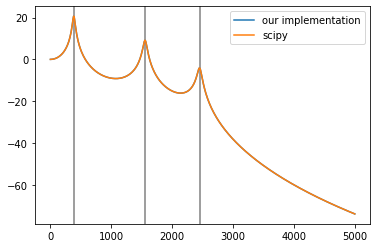

In [3]:
T, *xy = prior.sample(seed=jaxkey())
xy = np.array(xy)
x, y = np.split(xy, 2)

print(x)
print(y)

f = np.linspace(0, constants.FS_HZ/2, 500)
power = allpole.transfer_function_power_dB(f, x, y)

plot(f, power, label="our implementation")
for xi in x: axvline(xi, color="grey")

##
import scipy.signal

poles = -np.pi*y + 2*np.pi*(1j)*x
p = hstack([poles, conj(poles)])
k = prod(abs(p))

w, H = scipy.signal.freqresp(([], p, k), 2*pi*f)
plot(f, 20*log10(abs(H)), label="scipy")

legend();

The impulse response is not so great -- it's peak amplitude is more O(10) and can lash out to O(100) while we would like it more to be O(1).

0.016011818829067197

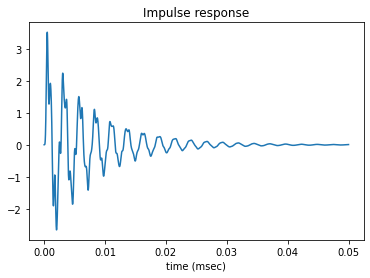

In [4]:
def scope(poles):
    t, dt = linspace(0, 50/1000, 100000, retstep=True) # msec
    c = core.pole_coefficients(poles/1000)
    Y = real(2*c[None,:]*np.exp(t[:,None]*poles[None,:]))
    y = np.sum(Y, axis=1)
    plot(t, y)
    title("Impulse response")
    xlabel("time (msec)")
    return dot(y,y)*dt
scope(poles[:3])

## Peak mergers in our TFB prior

About 15% of the power spectra of of samples from the TFB prior contain merged peaks (always F1 and F2).

We can apply rejection sampling to get rid of these. (This is actually not essential since even the AP case $K=3$ could cope with these by separating the peaks far enough -- it would just suffer a penalty in max likelihood attainable. In our 50 samples we only had one case of this.)

CPU times: user 22.1 s, sys: 7.23 ms, total: 22.1 s
Wall time: 22.1 s


(array([  1.,   0.,   0.,   0.,   0., 149.,   0.,   0.,   0., 850.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

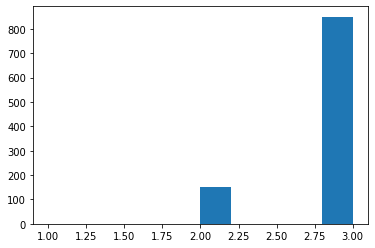

In [5]:
%%time
def sample_power_spectrum_dB(K=3, key=None):
    key = key if key is not None else jaxkey()
    f = constants.spectrum_frequencies()
    T, *xy = prior.sample(seed=key)
    xy = np.array(xy)
    x, y = np.split(xy, 2)
    x = x[:K]
    y = y[:K]
    power = allpole.transfer_function_power_dB(f, x, y)
    return f, x, y, power

def sample_K():
    f, x, y, power = sample_power_spectrum_dB(3, jaxkey())
    power = np.array(power)

    F, B = spectrum.get_formants_from_spectrum(
        f,
        power
    )
    
    K = len(F)
    return K

Ks = [sample_K() for _ in range(1000)]
hist(Ks)

## Try a fit

In [6]:
%%time
samples = bandwidth.get_TFB_samples()

[Memory]29.2s, 0.5min   : Loading get_TFB_samples...
CPU times: user 16.1 ms, sys: 342 µs, total: 16.4 ms
Wall time: 13.7 ms


{'T': 5.543638979659818,
 'F': array([ 662.74122865, 1204.66390864, 3564.30812483]),
 'B': array([ 51.98290238,  54.33027153, 118.93687559]),
 'f': array([0.000e+00, 1.000e+00, 2.000e+00, ..., 7.997e+03, 7.998e+03,
        7.999e+03]),
 'power': array([ 0.00000000e+00,  2.63437148e-05,  1.05375150e-04, ...,
        -8.79819339e+01, -8.79890538e+01, -8.79961726e+01])}

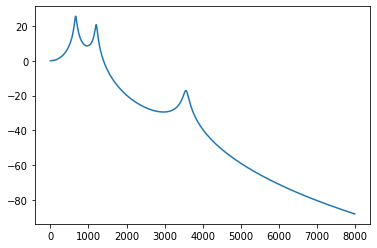

In [7]:
sample = samples[29]

plot(sample['f'], sample['power'])
sample

In [8]:
K=4
results = allpole.fit_TFB_sample(sample, K, 1111111222222)

[Memory]29.5s, 0.5min   : Loading run_nested...


In [9]:
fitted = allpole.get_fitted_TFB_samples()

[Memory]29.6s, 0.5min   : Loading get_TFB_samples...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading r

In [10]:
K = 10
sample_index = 40

def getfit(K, sample_index):
    return fitted[(K-3)*50+sample_index]

fit = getfit(K, sample_index)

sample = fit['sample']
results = fit['results']

Summary
nlive: 60
niter: 1886
ncall: 254296
eff(%):  0.765
logz: -39.715 +/-  0.683


None

'Information (bans)'

10.260158842947659

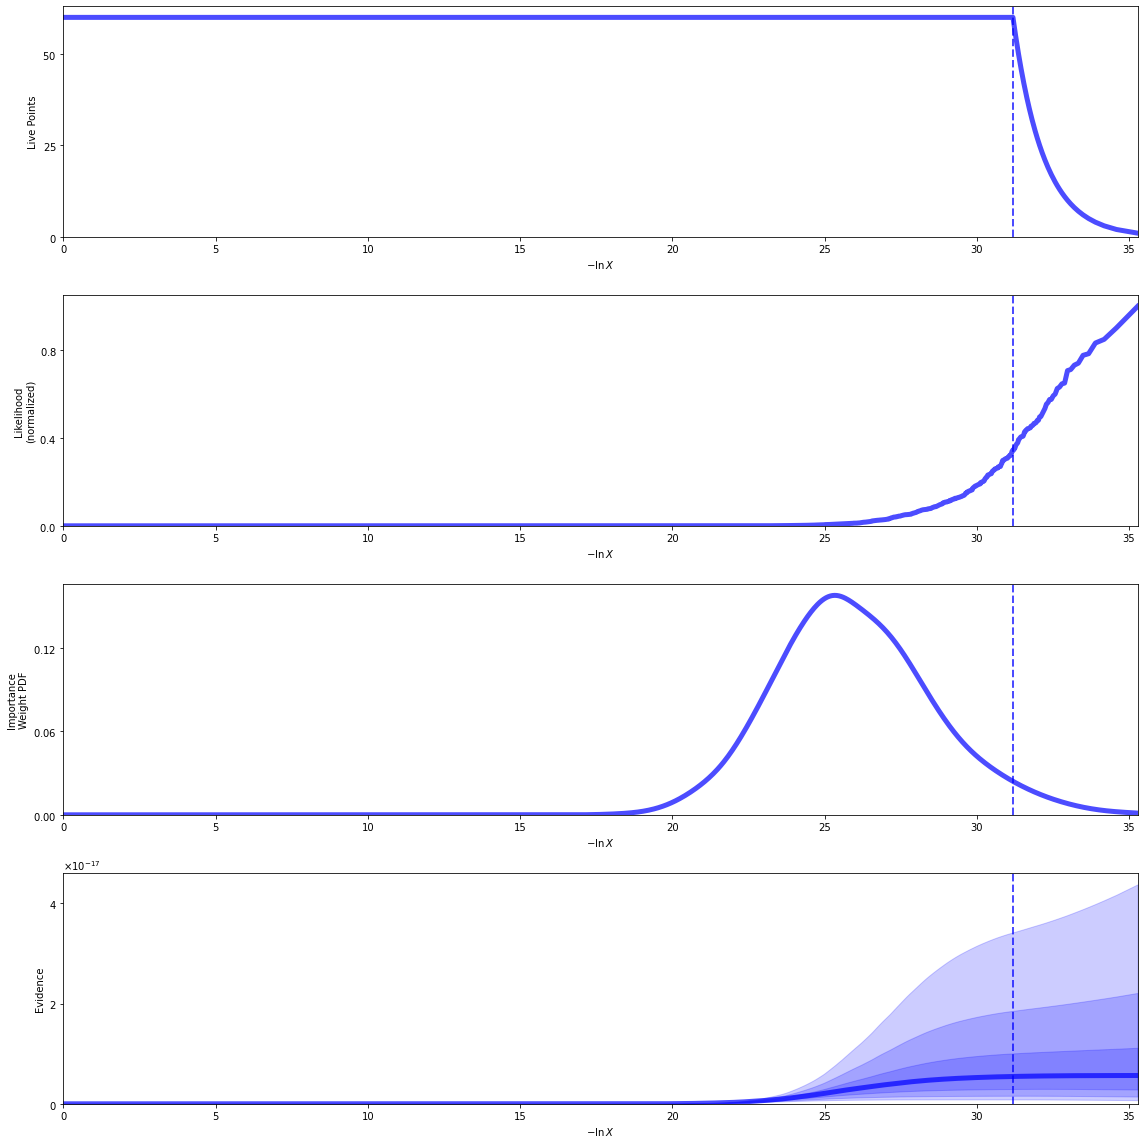

Quantiles:
x [(0.025, 277.53231008547556), (0.5, 309.6671614727962), (0.975, 347.12564505487285)]
Quantiles:
x [(0.025, 423.01900819005914), (0.5, 426.93307360115716), (0.975, 431.29670889649833)]
Quantiles:
x [(0.025, 1604.0876247415376), (0.5, 1785.6226382671662), (0.975, 1912.8102531581262)]
Quantiles:
x [(0.025, 2127.6339016763745), (0.5, 2317.2337517850765), (0.975, 2429.572077802934)]
Quantiles:
x [(0.025, 2432.7485253235645), (0.5, 2449.29482651273), (0.975, 2472.049176096119)]
Quantiles:
x [(0.025, 2823.818681879001), (0.5, 2877.2883278581867), (0.975, 2927.60945238724)]
Quantiles:
x [(0.025, 3409.93923920101), (0.5, 3799.143192499695), (0.975, 4339.602015370629)]
Quantiles:
x [(0.025, 3727.6334923581653), (0.5, 4368.5959306924615), (0.975, 4793.627959707817)]
Quantiles:
x [(0.025, 3759.2875240359217), (0.5, 4417.522559877986), (0.975, 4824.651488495778)]
Quantiles:
x [(0.025, 4466.624902678902), (0.5, 4831.320231145075), (0.975, 4990.508067201389)]
Quantiles:
y [(0.025, 1981.1

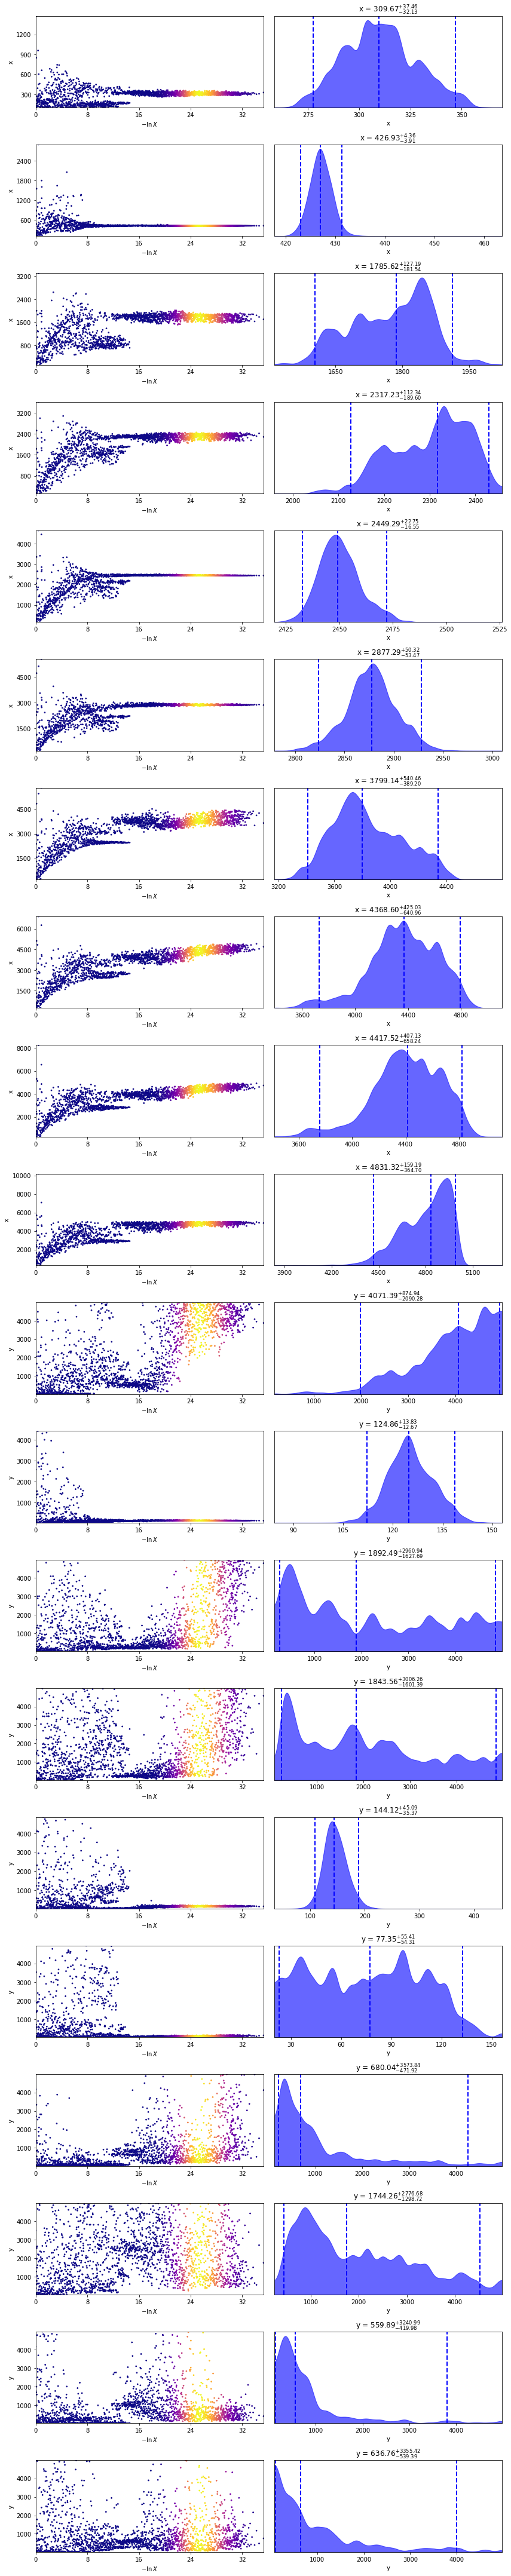

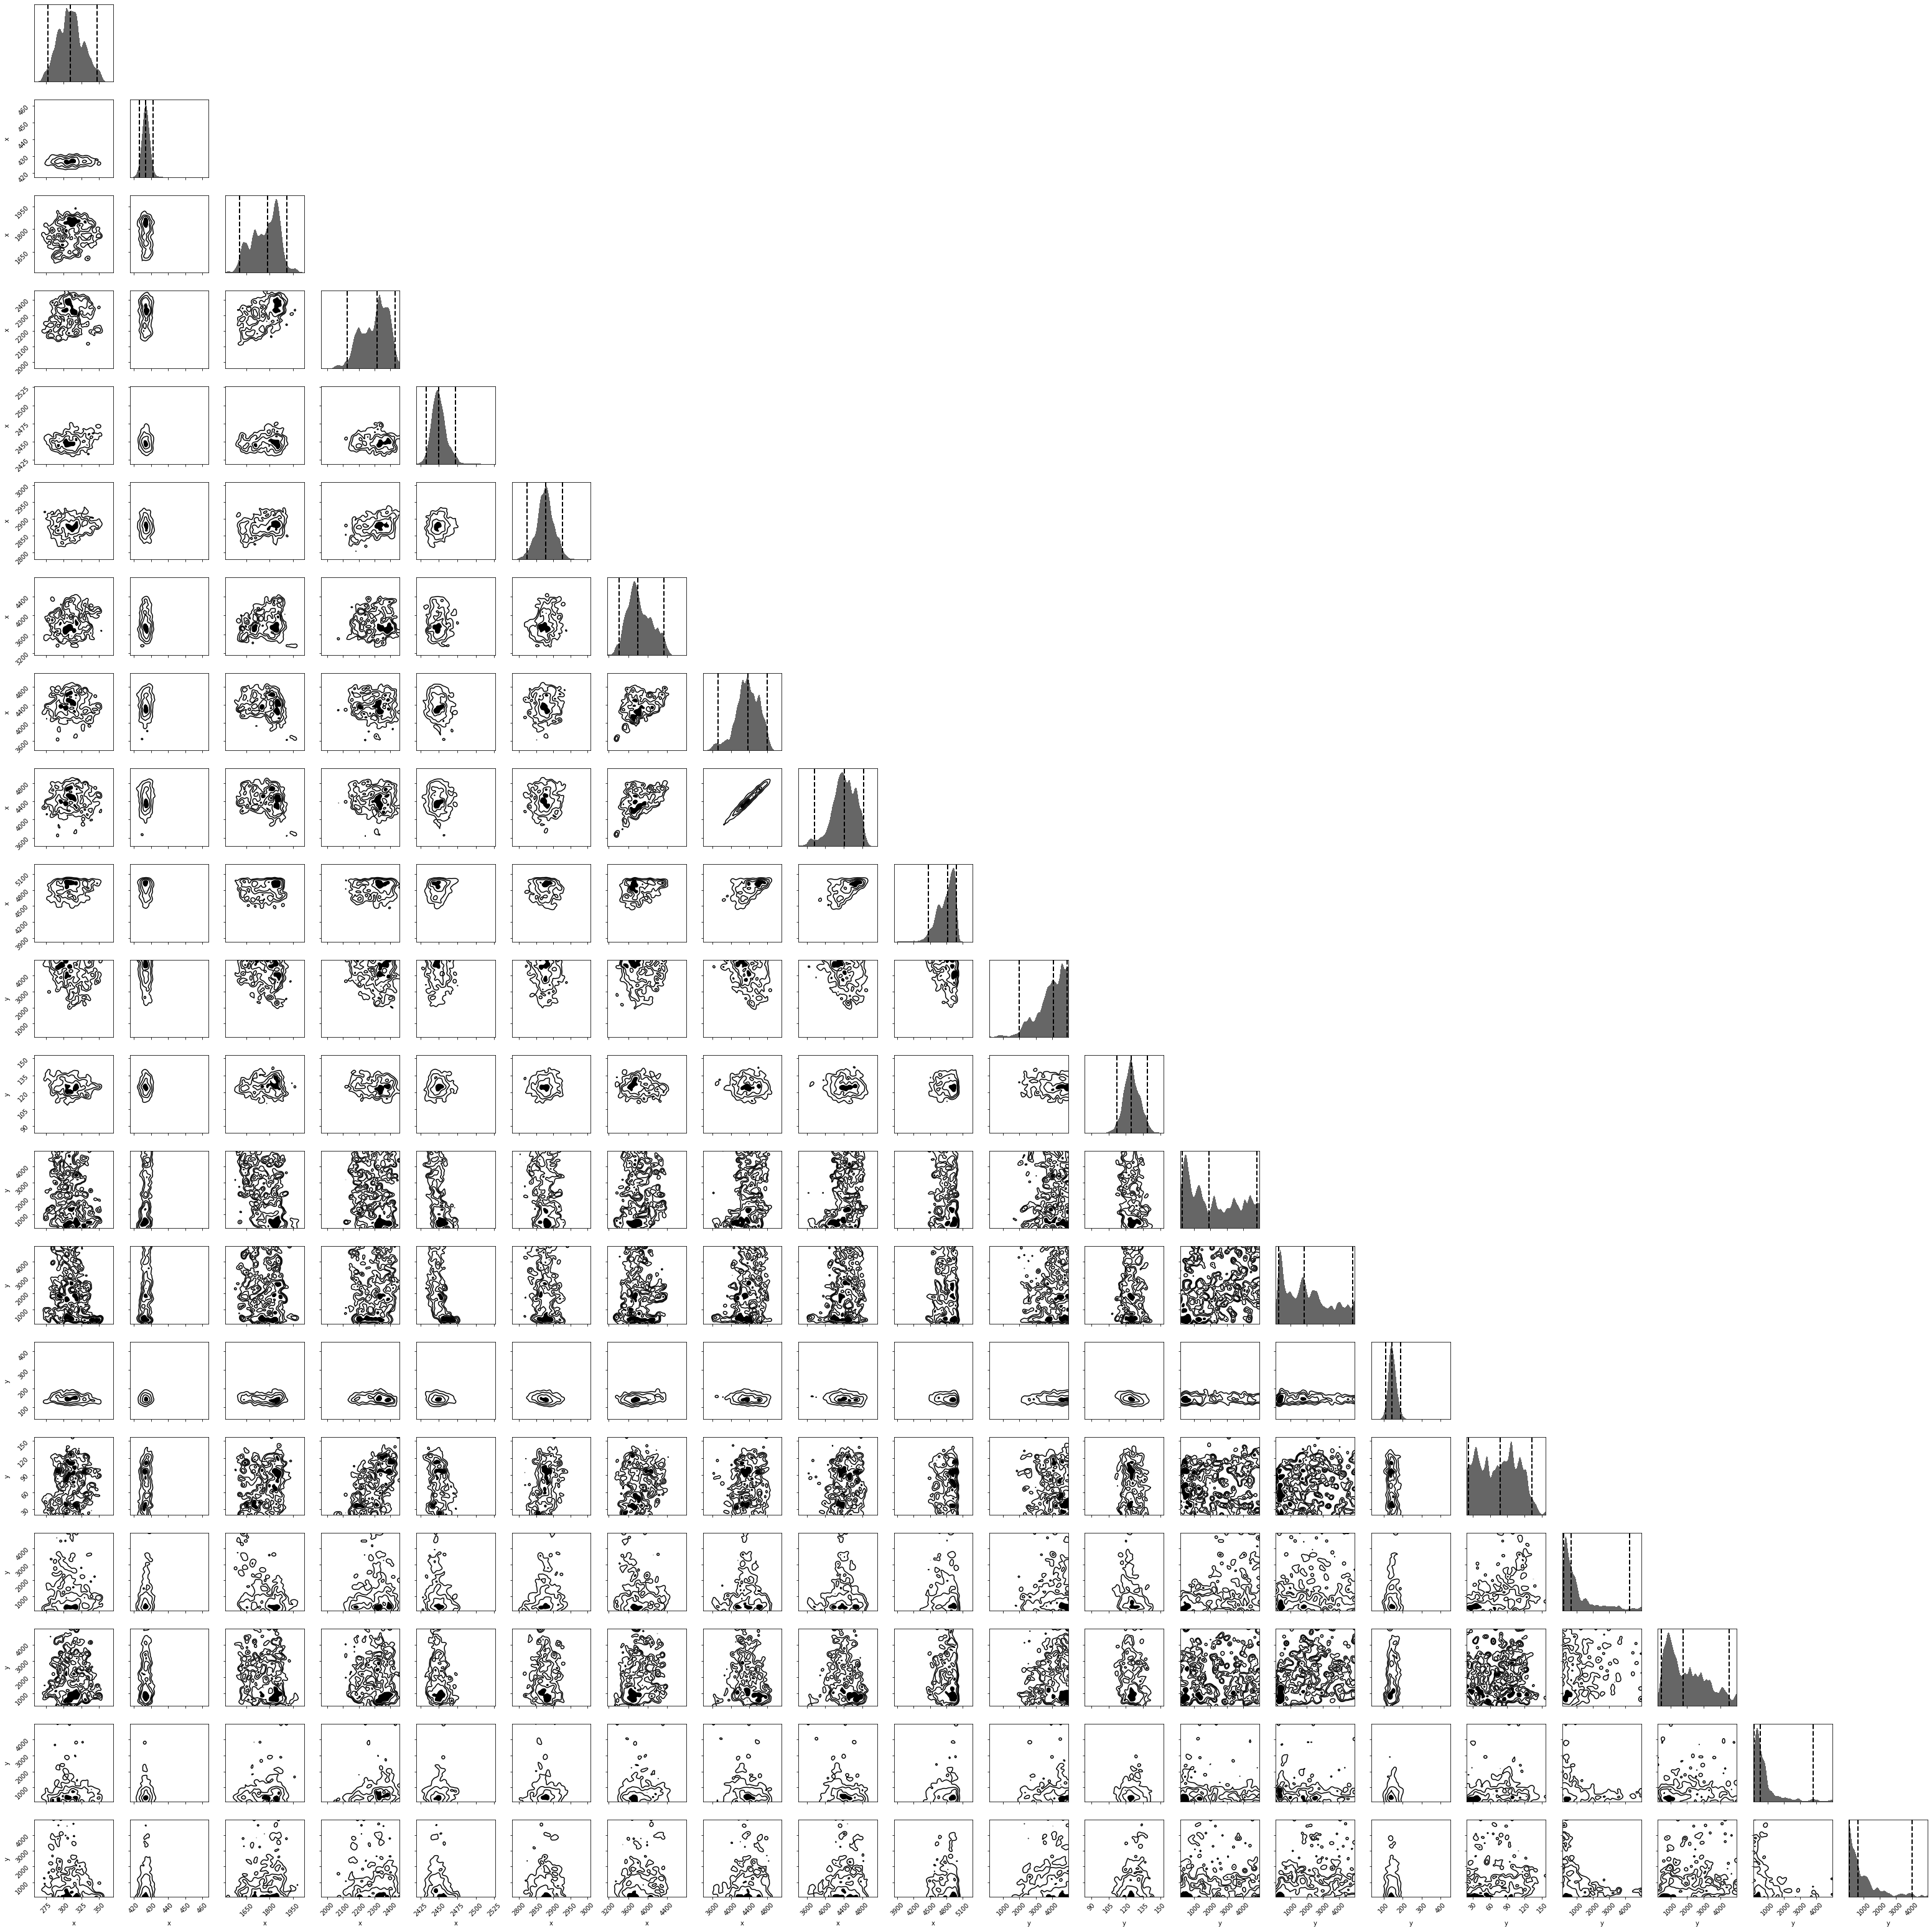

In [11]:
from lib import util

util.dyplot(results, (*["x"]*K, *["y"]*K)); # (1.25, 1)

-131.7481866097824 -120.41199826559247
0.44806297342229373 300.30154581365616 263.0404988832331
-130.84479402759902 -120.41199826559247
2.283264619317106 373.92337024909045 259.3903273127253
-137.43488895078636 -120.41199826559247
2.7934307085850083 211.7139264953432 286.6032678923724


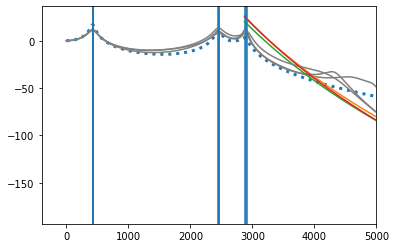

In [15]:
from vtr.prior.allpole import *

plot(sample['f'], sample['power'], ':', lw=3)

def unpack(params):
    x, y = np.split(params, 2)
    return x, y

def loglike_debug(
    params,
    f = sample['f'],
    F_true = sample['F'],
    B_true = sample['B'],
    sigma_F = np.array([2., 7, 29]),
    sigma_B = np.array([4., 14, 58]),
    tilt_target = constants.FILTER_SPECTRAL_TILT_DB,
    sigma_tilt = constants.SIGMA_TILT_DB
):
    x, y = unpack(params)
    
    power = transfer_function_power_dB(f, x, y)
    
    plot(f, power, "grey")
    
    try:
        F, B, context = spectrum.get_formants_from_spectrum(
            f, power, return_full=True
        )
    except np.linalg.LinAlgError:
        return -np.inf
    
    if len(F) != 3:
        return -np.inf
    
    tilt, interp = spectrum.fit_tilt(f, power, cutoff=F_true[-1], return_interp=True)
    print(tilt, allpole.analytical_tilt(K))
    
    plot(f[f > F_true[-1]], interp(f[f > F_true[-1]]))
    
    for Fi in F: axvline(Fi)
    
    F_err = np.sum(((F - F_true)/sigma_F)**2)
    B_err = np.sum(((B - B_true)/sigma_B)**2)
    tilt_err = ((tilt - tilt_target)/sigma_tilt)**2

    print(F_err, B_err, tilt_err)
    
    return -(F_err + B_err + tilt_err)/2

loglike_debug(util.resample_equal(results, 1).squeeze())
loglike_debug(util.resample_equal(results, 1).squeeze())
loglike_debug(util.resample_equal(results, 1).squeeze())

xlim(None, 5000);

In [ ]:
from vtr.prior import polezero

x, y = unpack(util.resample_equal(results, 1).squeeze())

##
poles = core.make_poles(y, x)
c = core.pole_coefficients(poles)
a = real(c + conj(c))
b = real((1j)*(c - conj(c)))
ab_AP = np.concatenate((a, b))

S = polezero.overlap_matrix(x, y)
mu2_analytical_sec = ab_AP.T @ S @ ab_AP
print("mu2(analytical) [msec] =", mu2_analytical_sec*1000)

##

fs = 1000 # kHz
dt = 1/fs # msec
t = np.arange(0., 50, dt) # msec

h = allpole.impulse_response(t, x, y)
plot(t, h)

mu2 = np.dot(h, h)*dt
print("mu2 [msec] =", mu2)

##

f = sample['f']

power_db = allpole.transfer_function_power_dB(f, x, y)
power = 10**(power_db/10)

show()
plot(f, power)

power_PZ = polezero.transfer_function_power_dB(f, x, y, ab_AP, normalize_gain=True)
plot(f, 10**(power_PZ/10), label="PZ")

##
scipy.integrate.trapezoid(power, f)/1000*2

In [ ]:
util.resample_equal(results, 5)

In [ ]:
from dgf import bijectors

post_samples = util.resample_equal(results, 100)[:,2:]

post_bounds = np.array([
    [(100., 5000.)]*K + [(20., 5000.)]*K,
]).squeeze()

b = bijectors.fit_nonlinear_coloring_bijector(
    post_samples, post_bounds, 1234567890000000000
)

In [ ]:
xy = b.forward(randn(2*K))
x, y = np.split(xy, 2)

print(x)
print(y)

poles = core.make_poles(y, x) # rad kHz

f = constants.spectrum_frequencies()
power = allpole.transfer_function_power_dB(f/1000, poles)



plot(f, power, label="our implementation")
ylim(None, max(power)/1.1)

F, B = spectrum.get_formants_from_spectrum(f, power)
for xi in F: axvline(xi, color="grey")


def fit_tilt2(
    f, power_spectrum, return_interp=False
):
    """Estimate tilt in dB/oct by linear regression in log domain -- see tilt.ipynb
    
    May return NaN in exceptional cases if very badly conditioned (such
    as an upwardly curving power spectrum). This is very rare.
    """
    w = (f - f[0])/(f[-1] - f[0])
    print(w)
    f2 = np.log2(f)
    f2[0] = 0.
    
    a, b = np.polyfit(f2, power_spectrum, 1, w=w**2)
    
    if return_interp:
        interp_log = np.poly1d([a, b])
        def interp(f): return interp_log(np.log2(f))
        return a, interp
    else:
        return a

def fit_tilt3(
    f, power_spectrum, return_interp=False
):
    """Estimate tilt in dB/oct by linear regression in log domain -- see tilt.ipynb
    
    May return NaN in exceptional cases if very badly conditioned (such
    as an upwardly curving power spectrum). This is very rare.
    """
    f = f[1::5]
    power_spectrum = power_spectrum[1::5]
    
    a, b = np.polyfit(np.log(f), power_spectrum, 1)
    
    if return_interp:
        interp_log = np.poly1d([a, b])
        def interp(f): return interp_log(np.log2(f))
        return a, interp
    else:
        return a

    
tilt, interp = spectrum.fit_tilt(f, power, return_interp=True)
print(tilt)
plot(f[300:], interp(f[300:]))

tilt, interp = fit_tilt2(f, power, return_interp=True)
print(tilt)
plot(f[300:], interp(f[300:]), lw=3)

tilt, interp = spectrum.fit_tilt(f, power, F[-1], return_interp=True)
print(tilt)
plot(f[300:], interp(f[300:]), lw=3)

## Aggregate

In [ ]:
def posterior_of_fitted_FBT_values(K, numsamples=100):
    def process():
        for fit in allpole.yield_fitted_TFB_samples():
            if fit['K'] == K:
                yield util.resample_equal(fit['results'], numsamples)

    return np.vstack(list(process()))

In [ ]:
Kpost = 10

post_samples = np.vstack(posterior_of_fitted_FBT_values(Kpost))

In [ ]:
import corner

fig = corner.corner(
    post_samples,
    labels=("rho", "h", *["x"]*Kpost, *["y"]*Kpost),
    show_titles=True,
    smooth=1.
);

In [ ]:
from dgf import bijectors

theta = post_samples[:,2:]

post_bounds = np.array([
    [(100., 5000.)]*Kpost + [(20., 5000.)]*Kpost,
]).squeeze()

b = bijectors.fit_nonlinear_coloring_bijector(
    theta, post_bounds, 1234567890000000
)

In [ ]:
for i in range(10):
    xy = b.forward(randn(2*Kpost))
    x, y = np.split(xy, 2)

    poles = core.make_poles(y, x) # rad kHz
    
    t, dt = linspace(0, 50, 100000, retstep=True) # msec
    c = core.pole_coefficients(poles)
    K = len(poles)
    Y = real(2*c[None,:]*np.exp(t[:,None]*poles[None,:]))
    y = np.sum(Y, axis=1)
    plot(t, y)
    title("Impulse response")
    xlabel("time (msec)")
    show()

In [ ]:
for i in range(10):
    xy = b.forward(randn(2*Kpost))
    x, y = np.split(xy, 2)

    f = constants.spectrum_frequencies()
    power = allpole.transfer_function_power_dB(f, x, y)

    plot(f, power + i*30, label="our implementation")
    
    print(spectrum.number_of_peaks(f, power), spectrum.fit_tilt(f, power))
    #for xi in x: axvline(xi, color="grey")

In [ ]:
rho_mean, h_mean = mean(post_samples[:,:2], axis=0)
rho_mean, h_mean, std(post_samples[:,:2], axis=0)

In [ ]:
nopeaks = []
tilts = []

for i in range(10000):
    xy = b.forward(randn(2*Kpost))
    x, y = np.split(xy, 2)

    poles = core.make_poles(y, x) # rad kHz

    f = constants.spectrum_frequencies()
    power = allpole.transfer_function_power_dB(f/1000, poles)
    
    F, B = spectrum.get_formants_from_spectrum(f, power)
    nopeaks += [len(F)]
    tilts += [spectrum.fit_tilt(f, power)]

hist(nopeaks, bins=50);
show()
hist(tilts, bins=50);
axvline(allpole.analytical_tilt(Kpost))